## Detect Liquid Racism in Antiracist documents
We have a set of 73 documents that have been classified into 2 basic categories. The Liquid Racism category and the Pura Antiracist Category. The documents are in Greek Language.
For the detection of texts, specific key-words were used, such as **«μετανάστης», «πρόσφυγας», «ρατσισμός», «αντι-ρατσισμός»** and their derivatives.
For our analysis we use the Spacy library, Sklearn.
Our basic steps in order to export some insights are the following:
1. Data Preparation(cleaning texts, remove stopwords, lemmatize)
2. Create Wordclouds for the whole corpus of texts and for each category seperately, in order to see some basic info regarding the vocabulary.
3. Create a similarity heatmap
4. Run a classification problem using sklearn library(tf-idf, classification algorithm using train and test)

### Download packages and Install libraries

In [ ]:
!pip install xlrd
!spacy download el_core_news_lg

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
from wordcloud import WordCloud
import seaborn as sns
import re
import numpy as np
import spacy
import sklearn
import statistics
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.metrics.pairwise import cosine_similarity
import gensim
from sklearn import preprocessing

### Read the file and export some basic descriptives

In [4]:
df = pd.read_excel('Source_Data.xlsx')
df1 = pd.DataFrame(df)

Source
Actionaid                                      1
Humanrights360                                 3
Koutipandoras.gr                               1
PRAKSIS                                        1
facebook                                      18
twitter                                       31
ΔΟΜ                                            3
ΕΡΤ                                            1
ΕΦΣΥΝ                                          7
Εθνική Επιτροπή για τα Δικαιώματα Ανθρώπου     1
Ελευθερος Τυπος                                1
Η Καθημερινή                                   1
Τα Νεα                                         2
Υπατη Αρμοστεία ΟΗΕ                            7
Name: id, dtype: int64


<Axes: xlabel='Source'>

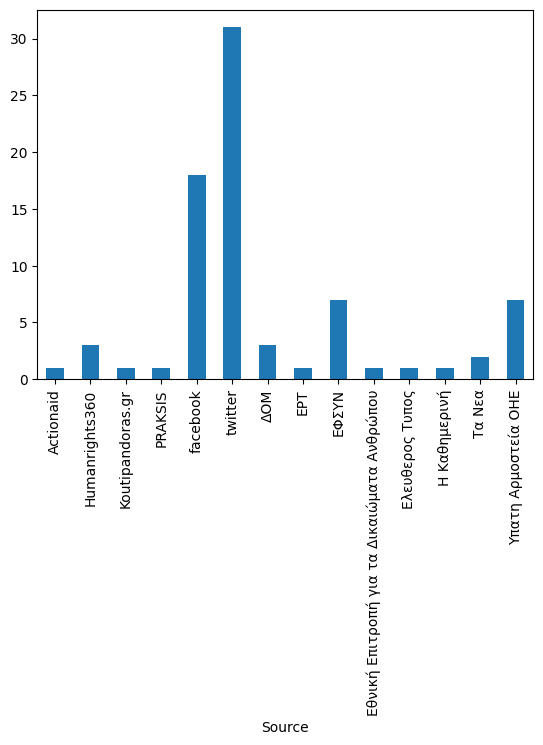

In [5]:
query1 = df1.groupby("Source")["id"].count()
print(query1)
query1.plot.bar(x="query2", y="")

Liquid_Racism
ΝΑΙ    64
ΟΧΙ    14
Name: id, dtype: int64


<Axes: xlabel='Liquid_Racism'>

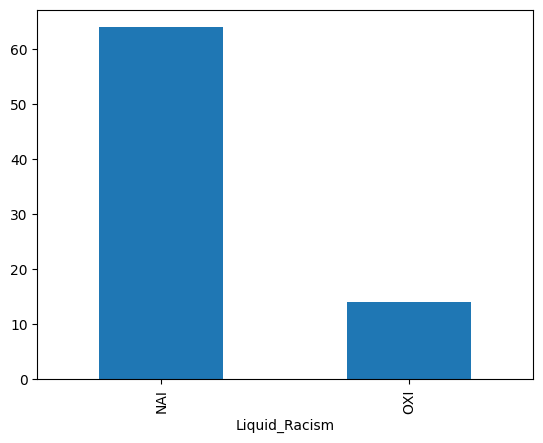

In [6]:
query2 = df1.groupby("Liquid_Racism")["id"].count()
print(query2)
query2.plot.bar(x="query2", y="")

Category
Αφομοίωση              2
Αφομοιωση_Διάκριση     7
Διάκριση              55
ΝΑ                     9
Name: id, dtype: int64


<Axes: xlabel='Category'>

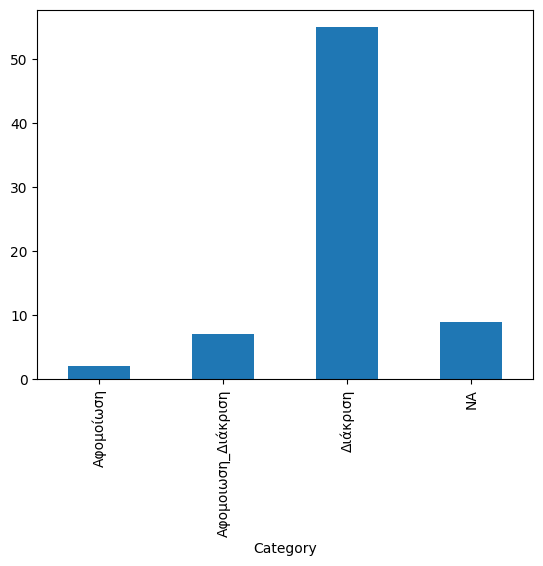

In [7]:
query3 = df1.groupby("Category")["id"].count()
print(query3)
query3.plot.bar(x="query3", y="")

Public_Sector
Επικαιρότητα                     13
Κρατικός_Φορεάς/Συλλογικότητα    16
Πολιτικός_Λόγος                  49
Name: id, dtype: int64


<Axes: xlabel='Public_Sector'>

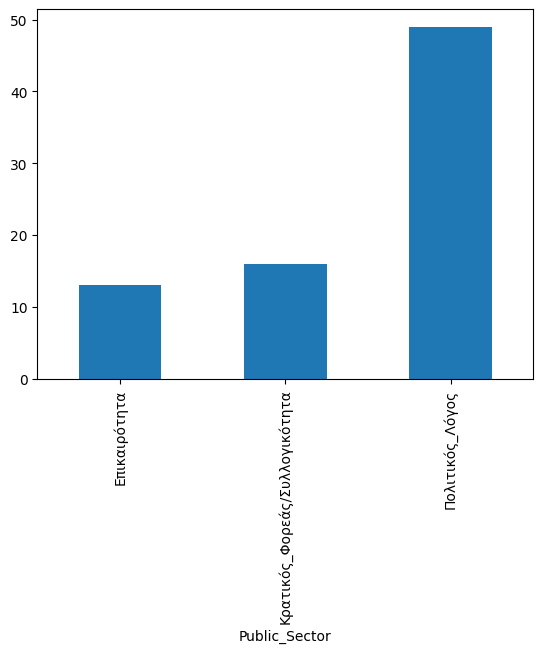

In [8]:
query4 = df1.groupby("Public_Sector")["id"].count()
print(query4)
query4.plot.bar(x="query4", y="")

## Text cleaning and transforming using Spacy

In [9]:
nlp = spacy.load("el_core_news_lg")

In [38]:
def preprocessor(text):
  #text = re.sub('<[^>]*>', '', text)
  #text = re.sub('[\W]+', '', text.lower())
  text = re.sub(r'προσφυγ.*|πρόσφυγ.*|προσφύγ.*', 'προσφυγ', text)
  text = re.sub(r'μεταν.*', 'μεταναστ', text)
  text = re.sub(r'ρατσισ.*', 'ρατσισ', text)
  return text

In [44]:
# Stop words
# Link to greek stop words: https://www.translatum.gr/forum/index.php?topic=3550.0?topic=3550.0
STOP_WORDS = set(
    """
αδιάκοπα αι ακόμα ακόμη ακριβώς άλλα αλλά αλλαχού άλλες άλλη άλλην
άλλης αλλιώς αλλιώτικα άλλο άλλοι αλλοιώς αλλοιώτικα άλλον άλλος άλλοτε αλλού
άλλους άλλων άμα άμεσα αμέσως αν ανά ανάμεσα αναμεταξύ άνευ αντί αντίπερα αντίς
άνω ανωτέρω άξαφνα απ απέναντι από απόψε άρα άραγε αρκετά αρκετές
αρχικά ας αύριο αυτά αυτές αυτή αυτήν αυτής αυτό αυτοί αυτόν αυτός αυτού αυτούς
αυτών αφότου αφού
βέβαια βεβαιότατα βρίσκω
γι για γιατί γρήγορα γύρω
δα δε δείνα δεν δεξιά δήθεν δηλαδή δι δια διαρκώς δικά δικό δικοί δικός δικού
δικούς διόλου δίπλα δίχως
εάν εαυτό εαυτόν εαυτού εαυτούς εαυτών έγκαιρα εγκαίρως εγώ εδώ ειδεμή είθε είμαι
είμαστε είναι εις είσαι είσαστε είστε είτε είχα είχαμε είχαν είχατε είχε είχες έκαστα
έκαστες έκαστη έκαστην έκαστης έκαστο έκαστοι έκαστον έκαστος εκάστου εκάστους εκάστων
εκεί εκείνα εκείνες εκείνη εκείνην εκείνης εκείνο εκείνοι εκείνον εκείνος εκείνου
εκείνους εκείνων εκτός εμάς εμείς εμένα εμπρός εν ένα έναν ένας ενός εντελώς εντός
εναντίον  εξής  εξαιτίας  επιπλέον επόμενη εντωμεταξύ ενώ εξ έξαφνα εξήσ εξίσου έξω επάνω
επειδή έπειτα επί επίσης επομένως εσάς εσείς εσένα έστω εσύ ετέρα ετέραι ετέρας έτερες
έτερη έτερης έτερο έτεροι έτερον έτερος ετέρου έτερους ετέρων ετούτα ετούτες ετούτη ετούτην
ετούτης ετούτο ετούτοι ετούτον ετούτος ετούτου ετούτους ετούτων έτσι εύγε ευθύς ευτυχώς εφεξής
έχει έχεις έχετε έχομε έχουμε έχουν εχτές έχω έως έγιναν  έγινε  έκανε  έξι  έχοντας
η ή ήδη ήμασταν ήμαστε ήμουν ήσασταν ήσαστε ήσουν ήταν ήτανε ήτοι ήττον
θα
ι ιδία ίδια ίδιαν ιδίας ίδιες ίδιο ίδιοι ίδιον ίδιοσ ίδιος ιδίου ίδιους ίδιων ιδίως ιι ιιι
ίσαμε ίσια ίσως
κ κάθε καθεμία καθεμίας καθένα καθένας καθενός καθετί καθόλου καθώς και κακά κακώς καλά
καλώς καμία καμίαν καμίας κάμποσα κάμποσες κάμποση κάμποσην κάμποσης κάμποσο κάμποσοι
κάμποσον κάμποσος κάμποσου κάμποσους κάμποσων κανείς κάνεν κανένα κανέναν κανένας
κανενός κάνω κάποια κάποιαν κάποιας κάποιες κάποιο κάποιοι κάποιον κάποιος κάποιου κάποιους
κάποιων κάποτε κάπου κάπως κατ κατά κάτι κατιτί κατόπιν κάτω κιόλας κλπ κοντά κτλ κυρίως
λιγάκι λίγο λιγότερο λόγω λοιπά λοιπόν
μα μαζί μακάρι μακρυά μάλιστα μάλλον μας με μεθαύριο μείον μέλει μέλλεται μεμιάς μεν
μερικά μερικές μερικοί μερικούς μερικών μέσα μετ μετά μεταναστ μεταξύ μέχρι μη μήδε μην μήπως
μήτε μια μιαν μιας μόλις μολονότι μονάχα μόνες μόνη μόνην μόνης μόνο μόνοι μονομιάς
μόνος μόνου μόνους μόνων μου μπορεί μπορούν μπρος μέσω  μία  μεσώ
να ναι νωρίς
ξανά ξαφνικά ο αυτός μου
ο οι όλα όλες όλη όλην όλης όλο ολόγυρα όλοι όλον ολονέν όλος ολότελα όλου όλους όλων
όλως ολωσδιόλου όμως όποια οποιαδήποτε οποίαν οποιανδήποτε οποίας οποίος οποιασδήποτε οποιδήποτε
όποιες οποιεσδήποτε όποιο οποιοδηήποτε όποιοι όποιον οποιονδήποτε όποιος οποιοσδήποτε
οποίου οποιουδήποτε οποίους οποιουσδήποτε οποίων οποιωνδήποτε όποτε οποτεδήποτε όπου
οπουδήποτε όπως ορισμένα ορισμένες ορισμένων ορισμένως όσα οσαδήποτε όσες οσεσδήποτε
όση οσηδήποτε όσην οσηνδήποτε όσης οσησδήποτε όσο οσοδήποτε όσοι οσοιδήποτε όσον οσονδήποτε
όσος οσοσδήποτε όσου οσουδήποτε όσους οσουσδήποτε όσων οσωνδήποτε όταν ότι οτιδήποτε
ότου ου ουδέ ούτε όχι οποία  οποίες  οποίο  οποίοι  οπότε  ος
πάνω  παρά  περί  πολλά  πολλές  πολλοί  πολλούς  που  πρώτα  πρώτες  πρώτη  πρώτο  πρώτος  πως
πάλι πάντα πάντοτε παντού πάντως πάρα πέρα πέρι περίπου περισσότερο πέρσι πέρυσι πια πιθανόν
πιο πίσω πλάι πλέον πλην ποιά ποιάν ποιάς ποιές ποιό ποιοί ποιόν ποιός ποιού ποιούς
ποιών πολύ πόσες πόση πόσην πόσης πόσοι πόσος πόσους πότε ποτέ πού πούθε πουθενά πρέπει
πριν προ προκειμένου πρόκειται πρόπερσι προς προσφυγ προτού προχθές προχτές πρωτύτερα πώς ρατσισ
σαν σας σε σεις σου στα στη στην στης στις στο στον στου στους στων συγχρόνως
συν συνάμα συνεπώς συχνάς συχνές συχνή συχνήν συχνής συχνό συχνοί συχνόν
συχνός συχνού συχνούς συχνών συχνώς σχεδόν
τα τάδε ταύτα ταύτες ταύτη ταύτην ταύτης ταύτοταύτον ταύτος ταύτου ταύτων τάχα τάχατε
τελευταία  τελευταίο  τελευταίος  τού  τρία  τρίτη  τρεις τελικά τελικώς τες τέτοια τέτοιαν
τέτοιας τέτοιες τέτοιο τέτοιοι τέτοιον τέτοιος τέτοιου
τέτοιους τέτοιων τη την της τι τίποτα τίποτε τις το τοι τον τοσ τόσα τόσες τόση τόσην
τόσης τόσο τόσοι τόσον τόσος τόσου τόσους τόσων τότε του τουλάχιστο τουλάχιστον τους τούς τούτα
τούτες τούτη τούτην τούτης τούτο τούτοι τούτοις τούτον τούτος τούτου τούτους τούτων τυχόν
των τώρα
υπ υπέρ υπό υπόψη υπόψιν ύστερα
χωρίς χωριστά σε
ω ως ωσάν ωσότου ώσπου ώστε ωστόσο ωχ
""".split()
)

In [45]:
# removing special characters and numbers
df1['Text'] = df1['Text'].str.lower()
remove_spec_char_numb = lambda x: re.sub(r'(http\S+)|rt|(@[A-Za-z0-9]+)|(\w+:\/\/\S+)|([()\-"#/;:<>{}`+=~|.!?_,])', '', str(x))
df1['Text'] = df1['Text'].apply(remove_spec_char_numb)
df1['Text2'] = df1['Text'].apply(lambda x : " ".join(word for word in x.split() if word not in STOP_WORDS))
df1['lemmatized'] = df1['Text2'].apply(lambda x: " ".join([preprocessor(y.lemma_) for y in nlp(x) if not preprocessor(y.lemma_) in STOP_WORDS]))

### Create a wordcloud for the entire dataframe

[('χώρα', 58), ('παιδί', 43), ('δομή', 39), ('Ελλάδα', 38), ('νέος', 30), ('ευρωπαϊκός', 30), ('σήμερα', 28), ('εε', 26), ('Ευρώπη', 26), ('άνθρωπος', 25)]


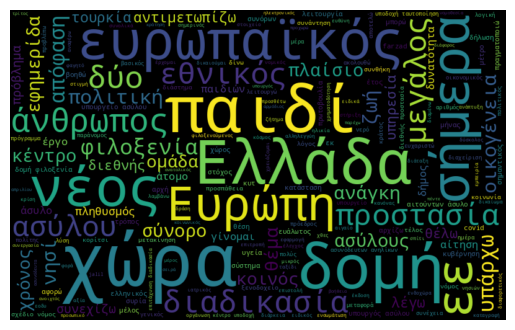

In [46]:
allwords = ' '.join( [twts for twts in df1['lemmatized']] )
wordcloud = WordCloud(width=800, height=500, random_state=21, max_font_size=119).generate(allwords)
# create a dictionary of word frequencies
text_dictionary = wordcloud.process_text(allwords)
# sort the dictionary
word_freq={k: v for k, v in sorted(text_dictionary.items(),reverse=True, key=lambda item: item[1])}
print(list(word_freq.items())[:10])
plt.imshow(wordcloud, interpolation = "bilinear")
plt.axis('off')
plt.show()

### Wordcloud for the Liquid Racism Texts

[('χώρα', 55), ('δομή', 39), ('Ελλάδα', 36), ('παιδί', 32), ('νέος', 30), ('ευρωπαϊκός', 29), ('σήμερα', 26), ('εε', 26), ('προστασία', 23), ('διαδικασία', 23), ('Ευρώπη', 23), ('εθνικός', 22), ('άνθρωπος', 22), ('φιλοξενία', 21), ('απόφαση', 20), ('ασύλου', 20), ('μεγάλος', 20), ('νησί', 19), ('δύο', 19), ('πολιτική', 18)]


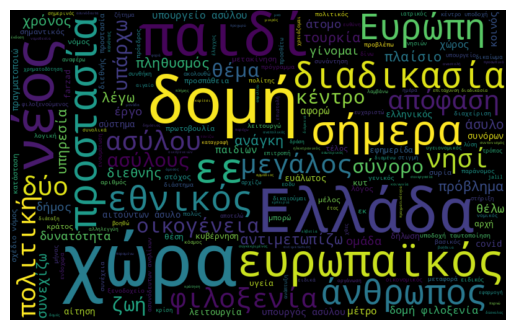

In [47]:
Liquid_Racism_Texts = df1[df1['Liquid_Racism']=='ΝΑΙ']
allwords_LR = ' '.join( [x for x in Liquid_Racism_Texts['lemmatized']] )
wordcloud = WordCloud(width=800, height=500, random_state=21, max_font_size=119).generate(allwords_LR)
text_dictionary = wordcloud.process_text(allwords_LR)
# sort the dictionary
word_freq={k: v for k, v in sorted(text_dictionary.items(),reverse=True, key=lambda item: item[1])}

#use words_ to print relative word frequencies
rel_freq=wordcloud.words_

#print results
print(list(word_freq.items())[:20])
plt.imshow(wordcloud, interpolation = "bilinear")
plt.axis('off')
plt.show()

### Wordcloud for the Pure Antiracist Texts

[('παιδί', 11), ('φαγητό', 8), ('νερό', 7), ('εφημερίδα', 6), ('δύο', 5), ('κοινωνία', 4), ('μήνας', 4), ('φωτογραφία', 4), ('κορίτσι', 4), ('βοηθώ', 4)]


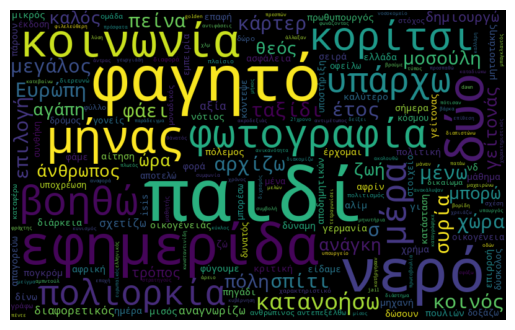

In [48]:
Pure_Antiracism_Texts = df1[df1['Liquid_Racism']=='ΟΧΙ']
allwords_PA = ' '.join( [x for x in Pure_Antiracism_Texts['lemmatized']] )
wordcloud = WordCloud(width=800, height=500, random_state=21, max_font_size=119).generate(allwords_PA)
# create a dictionary of word frequencies
text_dictionary = wordcloud.process_text(allwords_PA)
# sort the dictionary
word_freq={k: v for k, v in sorted(text_dictionary.items(),reverse=True, key=lambda item: item[1])}

#use words_ to print relative word frequencies
rel_freq=wordcloud.words_

#print results
print(list(word_freq.items())[:10])
plt.imshow(wordcloud, interpolation = "bilinear")
plt.axis('off')
plt.show()

### TF-IDF Transformation

In [49]:
#from sklearn.feature_extraction.text import TfidfVectorizer
v = TfidfVectorizer()
x = v.fit_transform(Liquid_Racism_Texts['lemmatized']).toarray()

In [50]:
# create a list with all the tfidf weights
weights = np.asarray(x.mean(axis=0)).ravel().tolist()
words_list = [word for line in Liquid_Racism_Texts['lemmatized'] for word in line.split()]
# apply the tfidf value to the corresponding term
weights_df = pd.DataFrame({'term': v.get_feature_names_out(), 'weight': weights})
# Sort the top 20 keywords
weights_df.sort_values(by='weight', ascending=False).head(20)

,term,weight
604,ασύλου,0.043438
851,διαδικασία,0.037960
1289,ευρωπαϊκός,0.036995
946,δομή,0.035828
2811,χώρα,0.034827
1084,ελλάδα,0.032345
202,άσυλο,0.031988
1779,νέος,0.029285
2187,προστασία,0.027852
1004,εε,0.024240


In [51]:
# create a list with all the tfidf weights
z = v.fit_transform(Pure_Antiracism_Texts['lemmatized']).toarray()
weights_z = np.asarray(z.mean(axis=0)).ravel().tolist()
words_list_z = [word for line in Pure_Antiracism_Texts['lemmatized'] for word in line.split()]
# apply the tfidf value to the corresponding term
weights_df1 = pd.DataFrame({'term': v.get_feature_names_out(), 'weight': weights_z})
# Sort the top 20 keywords
weights_df1.sort_values(by='weight', ascending=False).head(20)

,term,weight
391,παιδί,0.063511
285,κοινωνία,0.045464
102,βοηθώ,0.043634
272,κατανοήσω,0.042318
151,διαφορετικός,0.040951
76,αξία,0.038246
61,αναγνωρίζω,0.037193
441,πρωθυπουργός,0.034666
170,δύο,0.034320
339,μητσοτάκης,0.033873


## 2-grams based on tf-idf score

In [52]:
vectorizer1 = CountVectorizer(ngram_range = (2,2))
vectorizer2 = CountVectorizer(ngram_range = (2,2))
X1 = vectorizer1.fit_transform(Liquid_Racism_Texts['lemmatized'])
X2 = vectorizer2.fit_transform(Pure_Antiracism_Texts['lemmatized'])
features1 = (vectorizer1.get_feature_names_out())
features2 = (vectorizer2.get_feature_names_out())

In [53]:
# Applying TFIDF
vectorizer1 = TfidfVectorizer(ngram_range = (2,2))
vectorizer2 = TfidfVectorizer(ngram_range = (2,2))
X1 = vectorizer1.fit_transform(Liquid_Racism_Texts['lemmatized'])
X2 = vectorizer2.fit_transform(Pure_Antiracism_Texts['lemmatized'])
#scores = (X1.toarray())
#print("\n\nScores : \n", scores)

In [54]:
means_X1 = X1.mean(axis = 0)
means_X2 = X2.mean(axis = 0)
data1 = []
data2 =[]
for col, term in enumerate(features1):
  data1.append( (term, means_X1[0,col] ))
ranking1 = pd.DataFrame(data1, columns = ['term','rank'])
words1 = (ranking1.sort_values('rank', ascending = False))
print ("\n\nWords1 head : \n", words1.head(20))
for col, term in enumerate(features2):
  data2.append( (term, means_X2[0,col] ))
ranking2 = pd.DataFrame(data2, columns = ['term','rank'])
words2 = (ranking2.sort_values('rank', ascending = False))
print ("\n\nWords2 head : \n", words2.head(20))



Words1 head : 
                        term      rank
1888         δομή φιλοξενία  0.014074
1777      διεθνής προστασία  0.011367
192                covid 19  0.010817
5783        χορήγηση ασύλου  0.010461
1663      διαδικασία ασύλου  0.010357
1816       δικαιούμαι άσυλο  0.010341
1677    διαδικασία χορήγηση  0.010236
2576    ευρωπαϊκός πολιτική  0.010026
5576        υπουργός ασύλου  0.009854
2582        ευρωπαϊκός χώρα  0.009770
3079      κοινός ευρωπαϊκός  0.009634
5567       υπουργείο ασύλου  0.009453
575         αιτούντων άσυλο  0.009282
5553    υποδοχή ταυτοποίηση  0.008583
966     αποσυμφόρηση νησιών  0.008424
1667     διαδικασία εξέταση  0.008171
5202           σχέδιο νόμος  0.008140
1105   ασυνόδευτων ανηλίκων  0.008074
2197    ελλάδα αντιμετωπίζω  0.008071
2475  επιτάχυνση διαδικασία  0.007834


Words2 head : 
                        term      rank
596      σήμερα αντιμέτωπος  0.021537
364         κοινωνία σήμερα  0.021537
571              πρεσπών νδ  0.021537
239      ελλην

## Conclusion 1

Based on word frequency as this is captured in the wordcloud and on the tf-idf measure which indicates the word importance we can mention the following points:



*   Regarding the texts of liquid racism, we notice that words referring to the nation-state ('**χώρα**', '**Ελλάδα**') and words referring to a place of detention ('δομή') predominate.
*   Regarding the purely anti-racist texts, we notice that words denoting care, collectivity and solidarity dominate ('**παιδί**','**κοινωνία**' '**φαγητό**', '**νερό**')





## Similarity measurement

### We want to check the similarity between the liquid racism texts

In [55]:
array1 = df1[df1['Liquid_Racism']=='ΝΑΙ']['lemmatized'].values.tolist()
docs1 = [nlp(arr) for arr in array1]

In [56]:
labels = df1[df1['Liquid_Racism']=='ΝΑΙ']['Text_Title']
def create_heatmap(similarity, cmap = "YlGnBu"):
  df2 = pd.DataFrame(similarity)
  df2.columns = labels
  df2.index = labels
  fig, ax = plt.subplots(figsize=(5,5))
  sns.heatmap(df2, cmap=cmap)

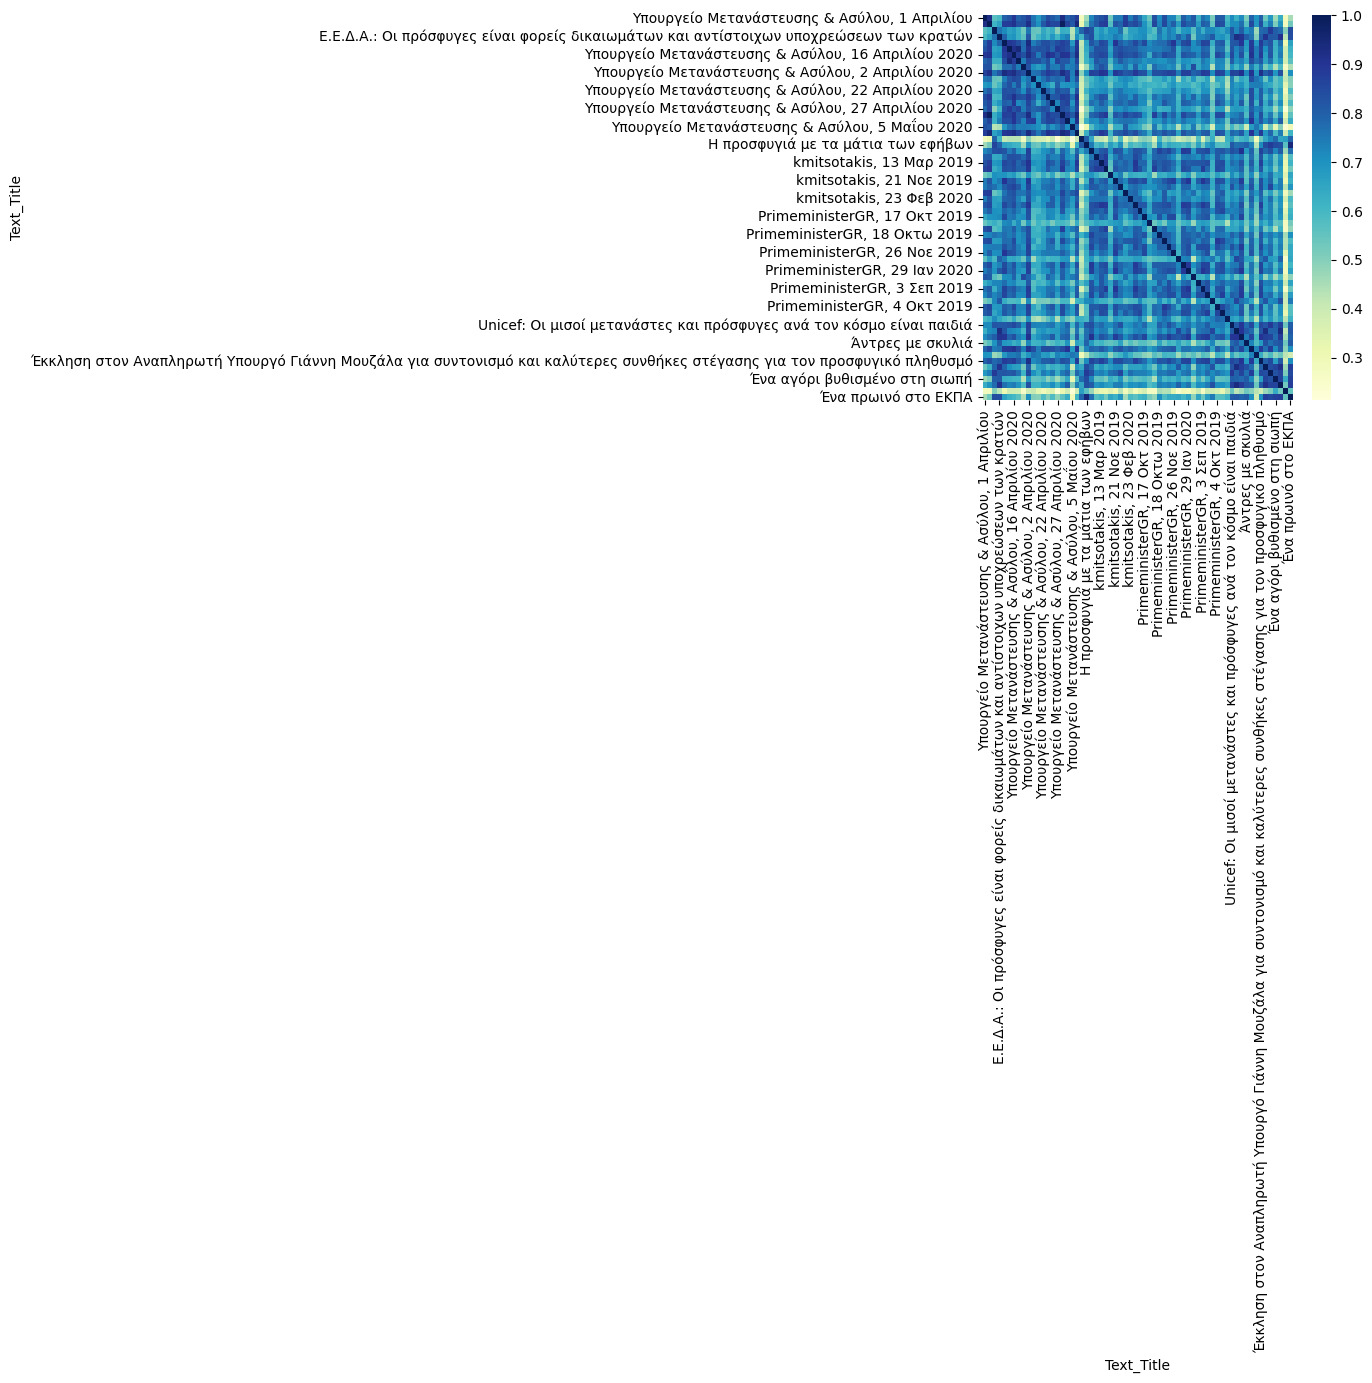

In [57]:
similarity = []
for i in range(len(docs1)):
  row = []
  for j in range(len(docs1)):
    row.append(docs1[i].similarity(docs1[j]))
  similarity.append(row)
create_heatmap(similarity)

In [58]:
print(statistics.mean(row))

0.6402751595168293


### We want to check the similarity between the text of Pure Antiracism

In [59]:
array2 = df1[df1['Liquid_Racism']=='ΟΧΙ']['lemmatized'].values.tolist()
docs2 = [nlp(arr) for arr in array2]

In [60]:
labels = df1[df1['Liquid_Racism']=='ΟΧΙ']['Text_Title']
def create_heatmap(similarity, cmap = "YlGnBu"):
  df2 = pd.DataFrame(similarity)
  df2.columns = labels
  df2.index = labels
  fig, ax = plt.subplots(figsize=(5,5))
  sns.heatmap(df2, cmap=cmap)

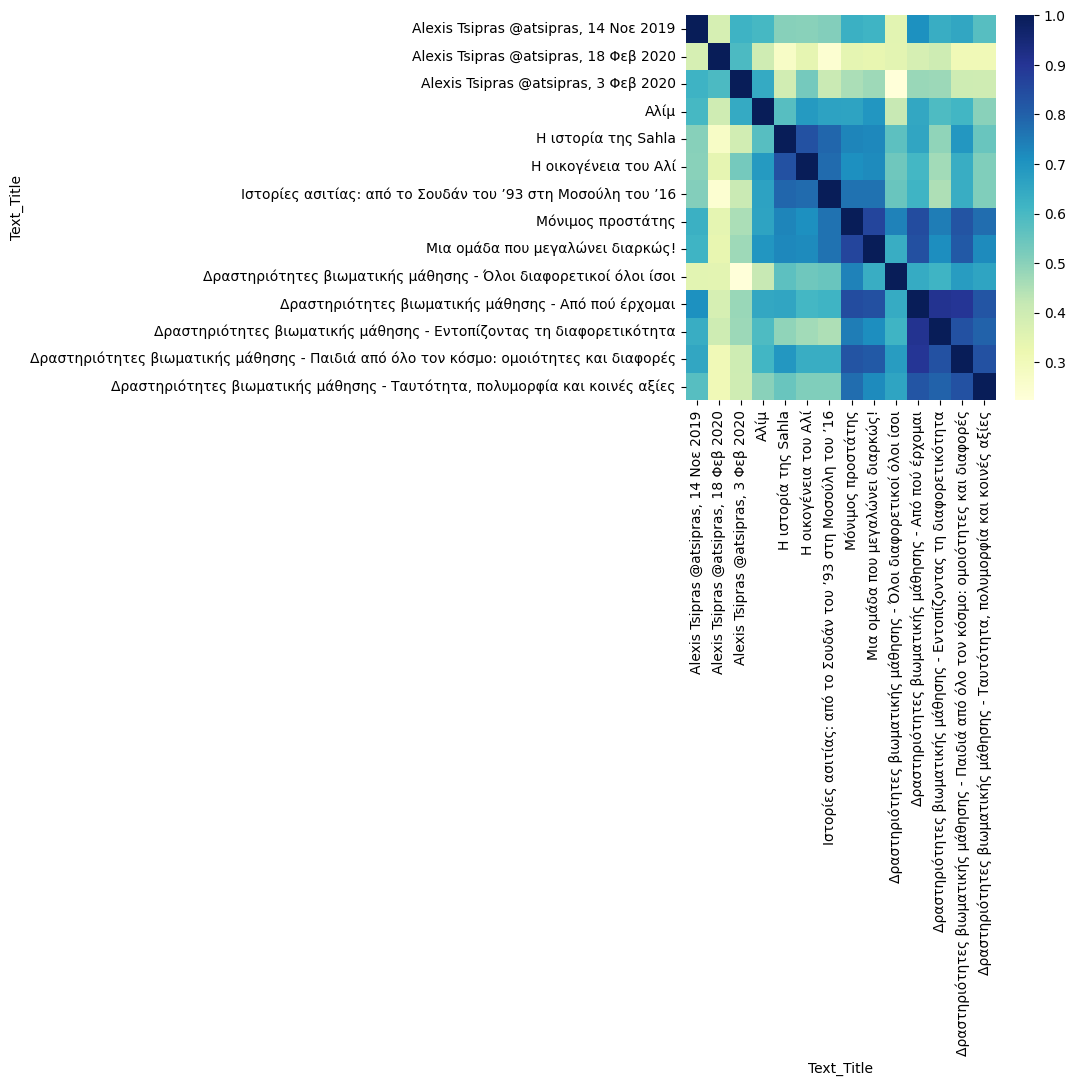

In [61]:
similarity = []
for i in range(len(docs2)):
  row = []
  for j in range(len(docs2)):
    row.append(docs2[i].similarity(docs2[j]))
  similarity.append(row)
create_heatmap(similarity)

In [62]:
print(statistics.mean(row))

0.6404504450625502
